In [1]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-07 00:21:31--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   185MB/s    in 3.5s    

2020-02-07 00:21:35 (179 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
os.listdir('gdrive/My Drive/Colab Notebooks/education')

['bert.h5', 'News_Category_Dataset_v2.json']

In [5]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers
from sklearn.model_selection import train_test_split


import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=f800f7d7cf0793033a4f8410a7a13e0212d1fedfd7f9ae1311710e2b8aaebaa6
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=0231e2be065bc538965a3350433de4ac4147567f3316760b290b8a90d23b8edc
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=45591d528cc79b7649771f11d1e3e356c39a1ed3d1fb3340be51bd947e201873
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=92fb5da659244a6d0631f359dee0dea6a09601e46fde0343cbde8612552f2856
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [9]:
os.listdir('bert')

['bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt',
 'multi_cased_L-12_H-768_A-12',
 'bert_config.json']

In [0]:
path = 'gdrive/My Drive/Colab Notebooks/education'

In [0]:
data = pd.read_json(os.path.join(path,'News_Category_Dataset_v2.json'), lines=True)

In [12]:
data.head(5)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [13]:
data.shape

(200853, 6)

In [14]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [0]:
category_names = np.array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'],)

In [0]:
data['category'] = data['category'].map(lambda x: "WORLDPOST" if x == 'THE WORLDPOST' else x)

In [16]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'WORLDPOST', 'GOOD NEWS', 'FIFTY', 'ARTS', 'WELLNESS', 'PARENTING',
       'HOME & LIVING', 'STYLE & BEAUTY', 'DIVORCE', 'WEDDINGS',
       'FOOD & DRINK', 'MONEY', 'ENVIRONMENT', 'CULTURE & ARTS'],
      dtype=object)

In [0]:
data['text'] = data['headline'] + " " + data['short_description']


DATA_COLUMN = "text"
LABEL_COLUMN = "category"

컬럼 카테고리들을 숫자로 변환

In [18]:
data[LABEL_COLUMN] = np.array(data[LABEL_COLUMN].factorize()[0])
data[LABEL_COLUMN].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

train_x, train_y 분류

In [0]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=123)

In [20]:
print(train_data.shape)
print(test_data.shape)

(150639, 7)
(50214, 7)


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
tokenizer = Tokenizer(token_dict)

In [24]:
print(tokenizer.tokenize("keras is reall fun."), tokenizer.tokenize("we can manipulate AI."))

['[CLS]', 'keras', 'is', 'real', '##l', 'fun', '.', '[SEP]'] ['[CLS]', 'we', 'can', 'mani', '##pul', '##ate', 'ai', '.', '[SEP]']


In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in data_df.index:
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)

    data_x, data_y = convert_data(data_df)

    return data_x, data_y

train 하는데 조금 오래걸림

In [0]:
train_x, train_y = load_data(train_data)
test_x, test_y = load_data(test_data)

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint( #bert.5h인가 불러오기
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output

  
  outputs = keras.layers.Dense(len(data['category'].unique()), activation='softmax',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

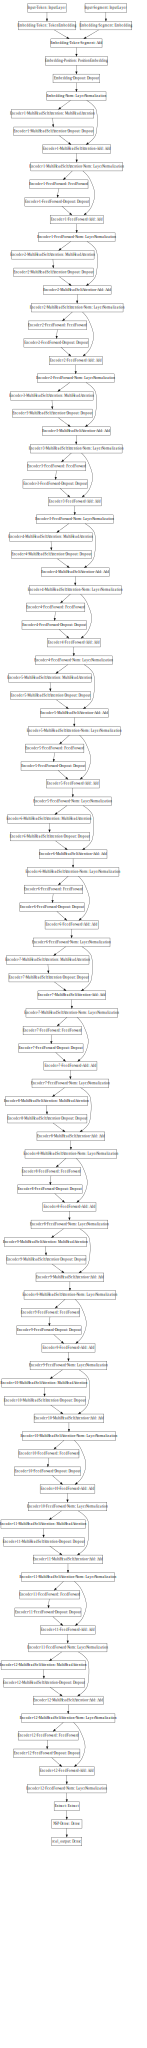

In [30]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


In [31]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-4acfe5f2b6e0>", line 7, in <module>
    history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1148, in fit
    self._make_train_function()
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 512, in _make_train_function
    loss=self.total_loss)
  File "/usr/local/lib/python3.6/dist-packages/keras_radam/optimizers.py", line 75, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]
  File "/usr/local/lib/python3.6/dist-packages/keras_radam/optimizers.py", line 75, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p),

KeyboardInterrupt: ignored

In [0]:
path = "gdrive/My Drive/Colab Notebooks/squad"

In [0]:
bert_model.save_weights(path+"/multi_classification.h5")

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/multi_classification.h5")

In [34]:
bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def category_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)

    category_index = np.argmax(predict)
    
    category =  category_names[category_index]
  
    return category

In [55]:
print(category_evaluation_predict("Wuhan hospital announces death of whistleblower doctor after confusion in state media"))

POLITICS


In [53]:
print(category_evaluation_predict("What next for Lionel Messi after the Instagram post that rocked Barcelona?"))

ENTERTAINMENT


In [54]:
print(category_evaluation_predict("Diana Taurasi on Kobe Bryant's effect on women's sport"))

SPORTS
